In [1]:
!cp /kaggle/input/gdcm-conda-install/gdcm.tar .
!tar -xvzf gdcm.tar
!conda install --offline ./gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2
!rm -rf ./gdcm.tar

gdcm/
gdcm/conda-4.8.4-py37hc8dfbb8_2.tar.bz2
gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2
gdcm/libjpeg-turbo-2.0.3-h516909a_1.tar.bz2

######################################################################## | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


# Imports

In [3]:
from PIL import Image
import pandas as pd
import os
import plotly_express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import pydicom
from pydicom import dcmread, read_file
from pydicom.data import get_testdata_file
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import wandb
import cv2
import ast
import glob
from tqdm.notebook import tqdm; tqdm.pandas();
import gc
import albumentations as A

In [ ]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb-key") 
wandb.login(key=wandb_api,relogin=True)

In [4]:
run = wandb.init(project='Final-Covid19-Detection',name='Exploratory Data Analysis')

wandb: Currently logged in as: alvaromoureupm. Use `wandb login --relogin` to force relogin


# Path Definition

In [4]:
BASE_PATH = '../input'
SIIM_DETECTION_PATH = os.path.join(BASE_PATH,'siim-covid19-detection')
SIIM_DETECTION_512_PATH = os.path.join(BASE_PATH,'siim-covid19-resized-to-512px-png')

# Util functions

In [5]:
from pydicom.pixel_data_handlers.util import apply_voi_lut

def read_xray(path, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array           
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data # Inverting the image
        
    data = data - np.min(data) 
    data = data / np.max(data) 
    data = (data * 255).astype(np.uint8)    
    return data

def get_image_metadata(study_id, df):
    data = df[df["id"] == study_id]
    
    if data["Negative for Pneumonia"].values == 1:
        label = "negative_for_pneumonia"
        label = "Negative for Pneumonia"
    elif data["Typical Appearance"].values == 1:
        label = "typical"
        label = "Typical Appearance"
    elif data["Indeterminate Appearance"].values == 1:
        label = "indeterminate"
        label = "Indeterminate Appearance"
    else:
        label = "atypical"
        label = 'Atypical Appearance'
        
    bboxes = list(data["boxes"].values)
    
    return label, bboxes

def get_box_cords(box):
    x1,y1,x2,y2 = box['x'],box['y'], box['x'] + box['width'], box['y'] + box['height']
    return (int(x1),int(y1),int(x2),int(y2))

def scale_bbox(img, bboxes,img_size):
    # Get scaling factor
    scale_x = img.shape[0]/img_size[0]
    scale_y = img.shape[1]/img_size[1]
    
    scaled_bboxes = []
    for bbox in bboxes:
        x = int(np.round(bbox[0]/scale_y, 4))
        y = int(np.round(bbox[1]/scale_x, 4))
        x1 = int(np.round(bbox[2]/scale_y, 4))
        y1= int(np.round(bbox[3]/scale_x, 4))

        scaled_bboxes.append([x, y, x1, y1]) # xmin, ymin, xmax, ymax
        
    return scaled_bboxes
    
def draw_bbox(image,
              box,
              label,
              color,
              label_size = 0.5,
              alpha_box = 0.3,
              alpha_label = 0.6):
    overlay_bbox = image.copy()
    overlay_label = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(),
                                              cv2.FONT_HERSHEY_SIMPLEX, label_size, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                  color, -1)    
    cv2.rectangle(overlay_label, (box[0], box[1]-7-text_height),
                  (box[0]+text_width+2, box[1]), (255, 255, 255), -1)
        
    output = cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                           color, 2)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, label_size, (255, 0, 0), 4, cv2.LINE_AA)
    
    return output

# Reading from SIIM-COVID-Detection

## Visualizing the Windowing Operation

In [6]:
dicom = pydicom.read_file('../input/siim-covid19-detection/train/000c9c05fd14/e555410bd2cd/51759b5579bc.dcm')
print(f'Bits Allocated {dicom.BitsAllocated}')
print(f'Bits Stored {dicom.BitsStored}')

Bits Allocated 16
Bits Stored 12


In [7]:
img = dicom.pixel_array
print(f'Min pixel value: {np.min(img)}')
print(f'Max pixel value: {np.max(img)}')

Min pixel value: 0
Max pixel value: 4095


### Before windowing

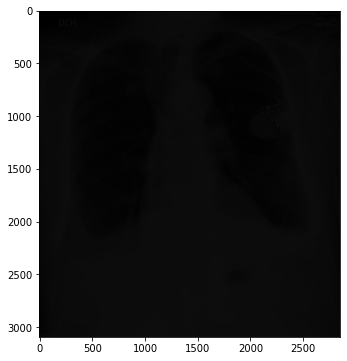

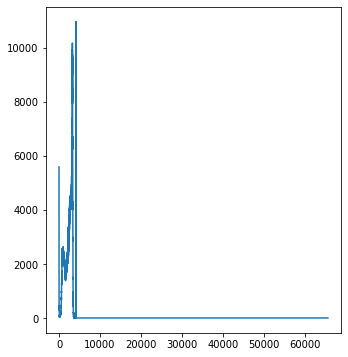

[[  82   81   80 ...    0    0    0]
 [  80   81   81 ...    0    0    0]
 [  81   81   82 ...    0    0    0]
 ...
 [ 896  880  859 ... 1956 1952 1924]
 [ 898  895  867 ... 1959 1965 1957]
 [ 875  880  879 ... 1953 2002 1983]]
image max pixel value:4095
image min pixel value: 0


In [8]:
hist, bin_edges = np.histogram(img, bins=2**16,range=(0,2**16))
plt.figure(figsize=(12,6))
plt.imshow(img,'gray',vmin=0,vmax=2**16)
plt.figure(figsize=(5.3,6))
plt.plot(hist)
plt.show()
print(img)
print(f'image max pixel value:{img.max()}')
print(f'image min pixel value: {img.min()}')

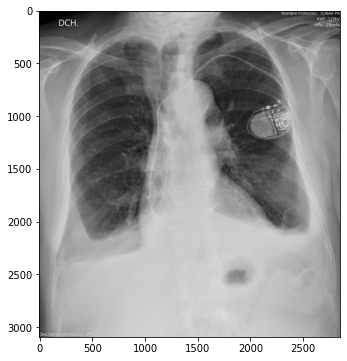

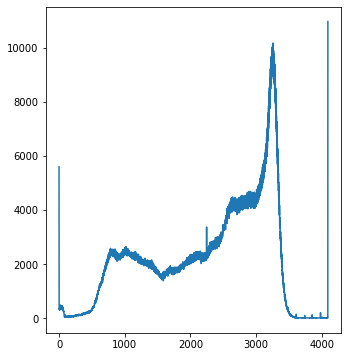

[[  82   81   80 ...    0    0    0]
 [  80   81   81 ...    0    0    0]
 [  81   81   82 ...    0    0    0]
 ...
 [ 896  880  859 ... 1956 1952 1924]
 [ 898  895  867 ... 1959 1965 1957]
 [ 875  880  879 ... 1953 2002 1983]]
image max pixel value:4095
image min pixel value: 0


In [9]:
hist, bin_edges = np.histogram(img, bins=2**12,range=(0,2**12))
plt.figure(figsize=(12,6))
plt.imshow(img,'gray',vmin=0,vmax=2**12)
plt.figure(figsize=(5.3,6))
plt.plot(hist)
plt.show()
print(img)
print(f'image max pixel value:{img.max()}')
print(f'image min pixel value: {img.min()}')

### Converting to 8-bit

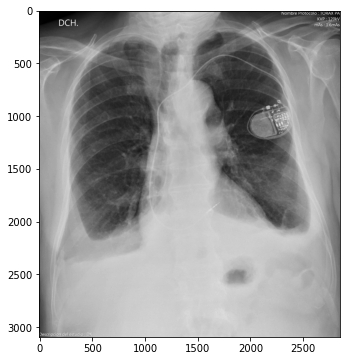

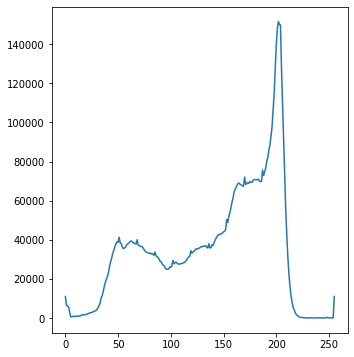

[[  5   5   4 ...   0   0   0]
 [  4   5   5 ...   0   0   0]
 [  5   5   5 ...   0   0   0]
 ...
 [ 55  54  53 ... 121 121 119]
 [ 55  55  53 ... 121 122 121]
 [ 54  54  54 ... 121 124 123]]
image max pixel value:255
image min pixel value: 0


In [10]:
img_8_bit = (img/img.max())*255
img_8_bit = np.uint8(img_8_bit)
plt.figure(figsize=(6,6))
plt.imshow(img,'gray')
plt.figure(figsize=(5.3,6))
hist,bin_edges = np.histogram(img_8_bit,bins = 256,range=(0,255))
plt.plot(hist)
plt.show()
print(img_8_bit)
print(f'image max pixel value:{img_8_bit.max()}')
print(f'image min pixel value: {img_8_bit.min()}')

### Combined Plot

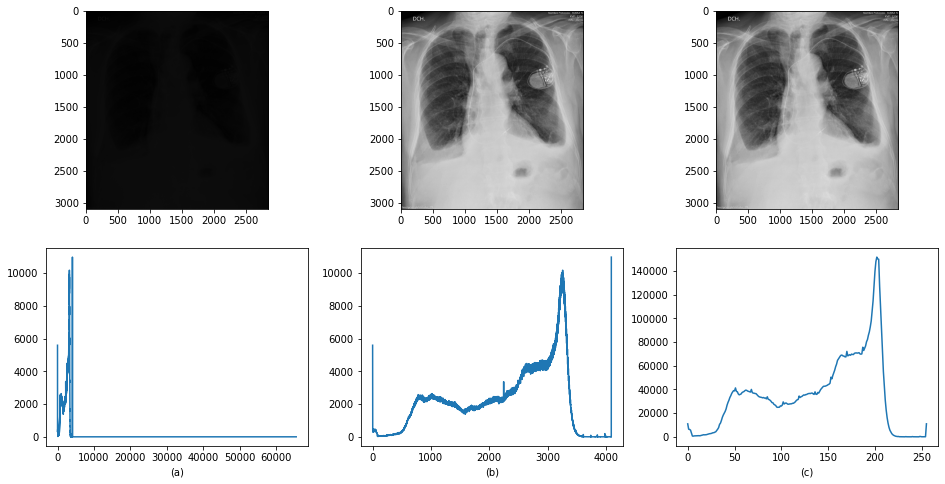

In [11]:
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(16,8))
hist, bin_edges = np.histogram(img, bins=2**16,range=(0,2**16))
ax[0,0].imshow(img,'gray',vmin=0,vmax=2**16)
ax[1,0].plot(hist)
ax[1,0].set_xlabel('(a)')
hist, bin_edges = np.histogram(img, bins=2**12,range=(0,2**12))
ax[0,1].imshow(img,'gray',vmin=0,vmax=2**12)
ax[1,1].plot(hist)
ax[1,1].set_xlabel('(b)')

img_8_bit = (img/img.max())*255
img_8_bit = np.uint8(img_8_bit)
ax[0,2].imshow(img,'gray')
hist,bin_edges = np.histogram(img_8_bit,bins = 256,range=(0,255))
ax[1,2].plot(hist)
ax[1,2].set_xlabel('(c)')
fig.show()

## Organizing metadata

In [14]:
image_df = pd.read_csv(os.path.join(SIIM_DETECTION_PATH,'train_image_level.csv'))
study_df = pd.read_csv(os.path.join(SIIM_DETECTION_PATH,'train_study_level.csv'))

In [15]:
study_df['StudyInstanceUID'] = study_df['id'].apply(lambda x: x.replace('_study',''))
study_df.drop('id',axis=1,inplace=True)
train_df = image_df.merge(study_df,on='StudyInstanceUID')
train_df['id'] = train_df['id'].apply(lambda x: x.replace('_image',''))
train_df.sort_values(by='StudyInstanceUID',ascending=True).head(3)

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
2651,65761e66de9f,"[{'x': 720.65215, 'y': 636.51048, 'width': 332...",opacity 1 720.65215 636.51048 1052.84563 1284....,00086460a852,0,1,0,0
2152,51759b5579bc,NaN,none 1 0 0 1 1,000c9c05fd14,0,0,0,1
6098,f6293b1c49e2,NaN,none 1 0 0 1 1,00292f8c37bd,1,0,0,0


In [16]:
train_df['StudyInstanceUID'].value_counts()

0fd2db233deb    9
a7335b2f9815    7
8943d1d85097    6
a4e94133d95a    5
a0254bf8a96e    5
               ..
e057d156dc1b    1
f556a329c873    1
206b9724427d    1
dbf24d77289c    1
7d82d53204b8    1
Name: StudyInstanceUID, Length: 6054, dtype: int64

In [12]:
os.walk('../input/siim-covid19-detection/train')

<generator object walk at 0x7f4789b4fbd0>

In [17]:
def get_absolute_file_paths(directory):
    all_abs_file_paths = []
    for dirpath,_,filenames in tqdm(os.walk(directory)):
        for f in filenames:
            all_abs_file_paths.append(os.path.abspath(os.path.join(dirpath, f)))
    return all_abs_file_paths

all_dcm_paths_train = get_absolute_file_paths('../input/siim-covid19-detection/train')
train_df["dcm_path"] = train_df["id"].progress_apply(lambda x: [z for z in all_dcm_paths_train if x in z][-1])

0it [00:00, ?it/s]

  0%|          | 0/6334 [00:00<?, ?it/s]

## Visualizing a single image with bounding boxes

In [18]:
image_id = 'dde89852ae66'

In [19]:
image_df['boxes'].values[0]

"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]"

In [28]:
image_df = train_df[train_df['id']==image_id]
image = read_xray(image_df['dcm_path'].values[0])
boxes = eval(image_df['boxes'].values[0])

for box in boxes:
    box_cords = get_box_cords(box)
    draw_bbox(image,box_cords,'opacity',(0,0,255))


## Creating DataFrame with all image paths

### Number of each category

In [29]:
negative = train_df[train_df['Negative for Pneumonia']==1]['Negative for Pneumonia'].count()
typical = train_df[train_df['Typical Appearance']==1]['Typical Appearance'].count()
indeterminated = train_df[train_df['Indeterminate Appearance']==1]['Indeterminate Appearance'].count()
atypical = train_df[train_df['Atypical Appearance']==1]['Atypical Appearance'].count()

In [30]:
print(negative + atypical + indeterminated + typical)
fig = px.bar(x=['Negative for Pneumonia','Typical Appearance','Indeterminate Appearance','Atypical Appearance'],
      y = [negative,typical,indeterminated,atypical],color = ['Negative for Pneumonia','Typical Appearance','Indeterminate Appearance','Atypical Appearance'],title='Class Count')
fig.show()


6334


In [ ]:
#wandb.log({'covid_class_count':fig})

### Bounding Box count

In [31]:
bounding_box_df = train_df['label'].apply(lambda x:x.split(' ')[0]).value_counts().reset_index()
print(bounding_box_df.head())
box_count_fig = px.bar(bounding_box_df,x='index',y='label',color='index',title='Percentage of images with bounding box',text_auto=True)
box_count_fig.show()

     index  label
0  opacity   4294
1     none   2040


In [ ]:
wandb.log({'% of images with boundng box':box_count_fig})

### Number of images per study

In [32]:
n_images_df = train_df["StudyInstanceUID"].value_counts().reset_index().sort_values("StudyInstanceUID", ascending=False)
print(n_images_df.head(2))
n_images_fig = px.bar(n_images_df[:100],x='index',y='StudyInstanceUID',color='StudyInstanceUID',title='Number of images per study')
n_images_fig.show()

          index  StudyInstanceUID
0  0fd2db233deb                 9
1  a7335b2f9815                 7


In [ ]:
wandb.log({'Number of images per study':n_images_fig})

In [ ]:
create_wandb_hist(x_data=train_df["StudyInstanceUID"], 
                  x_name="Image Freq", title="No. images per study", 
                  log="hist")

## Image view

In [34]:
id = 'dde89852ae66'
test_dicom = train_df[train_df['id']==id]['dcm_path'].values[0]

### Reading from DICOM files

In [35]:
ds = pydicom.dcmread(test_dicom)
ds

/opt/conda/lib/python3.7/site-packages/pydicom/valuerep.py:290: UserWarning:

Invalid value for VR UI: '03a65300fa41'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.

/opt/conda/lib/python3.7/site-packages/pydicom/valuerep.py:290: UserWarning:

Invalid value for VR UI: 'dde89852ae66'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.

/opt/conda/lib/python3.7/site-packages/pydicom/valuerep.py:290: UserWarning:

Invalid value for VR UI: '2cf2b94084ff'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.

/opt/conda/lib/python3.7/site-packages/pydicom/valuerep.py:290: UserWarning:

Invalid value for VR UI: 'e65d4dbf38f4'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.



Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 198
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10.474.3138682241938258086277500060704330134
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: 03a65300fa41
(0008, 0018) SOP Instance UID                    UI: dde89852ae66
(0008, 0020) S

In [36]:
# Accesing individual fields
print(f'Patients gender: {ds.PatientSex}')
print(f'Image pixels: {ds.BitsStored}')
print(f'Photometric interpretation: {ds.PhotometricInterpretation}')
print(f'Image shape: {ds.pixel_array.shape}')

Patients gender: F
Image pixels: 8
Photometric interpretation: MONOCHROME2
Image shape: (3480, 4240)


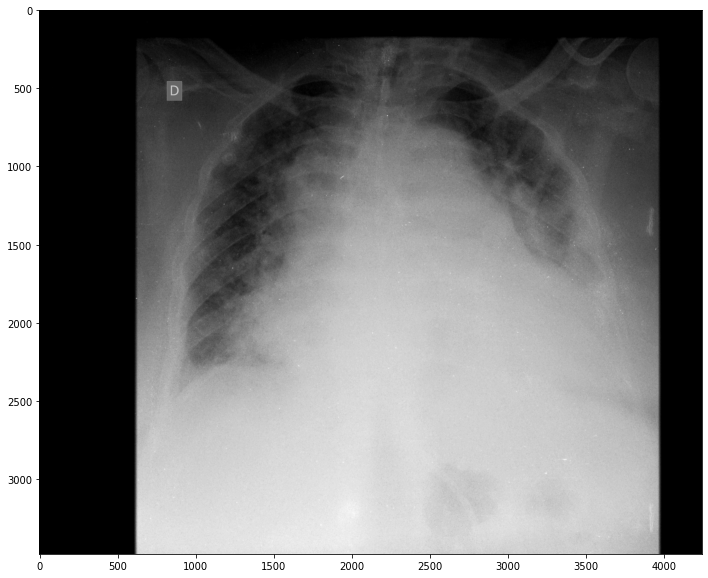

In [37]:
fig = plt.figure(figsize=(15,10))
plt.imshow(read_xray(test_dicom),'gray')

In [38]:
train_df[train_df['id']==id].head()['boxes'].values

array(["[{'x': 2327.91656, 'y': 482.41669, 'width': 1420.00015, 'height': 2240}, {'x': 707.91656, 'y': 472.41669, 'width': 1490, 'height': 1950}]"],
      dtype=object)

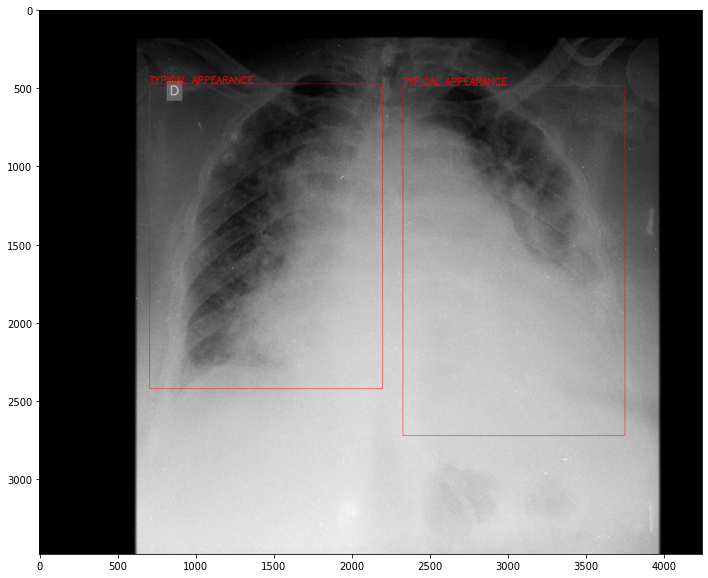

In [39]:
label,boxes = get_image_metadata(id,train_df)
boxes_coordinates =[]
for box in ast.literal_eval(boxes[0]):
    boxes_coordinates.append(get_box_cords(box))

img = read_xray(test_dicom)
color_img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
for box in boxes_coordinates:
    color_img = draw_bbox(color_img,box,label,(255,0,0),label_size=2)
fig = plt.figure(figsize=(15,10))
plt.imshow(color_img)
#plt.imsave('/kaggle/working/test_img.png',color_img)
    

### Testing box resizing with a single image

In [40]:
new_img_size = (512,512)
(color_img.shape[0]/new_img_size[0],color_img.shape[1]/new_img_size[1])

(6.796875, 8.28125)

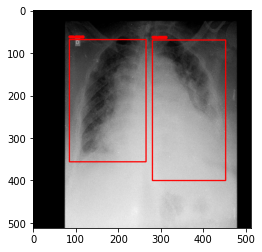

In [41]:
new_img_size = (512,512)
color_img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
re_color_img = cv2.resize(color_img,new_img_size)
ratio = (color_img.shape[0]/new_img_size[0],color_img.shape[1]/new_img_size[1])

for box in boxes_coordinates:
    box_re = (int(box[0]/ratio[1]) ,int(box[1]/ratio[0]) ,int(box[2]/ratio[1]) ,int(box[3]/ratio[0]) )
    re_color_img = draw_bbox(re_color_img,box_re,label,(255,0,0),label_size=0.1)   
plt.imshow(re_color_img)

## Reading Dicom Images -> Plotting Bounding Boxes -> Saving to Wandb

In [12]:
class_label_to_id = {
    'opacity':0
}

class_id_to_label = {
    0:'opacity'
}

In [13]:
def wandb_bbox(image, bboxes, true_label, class_label_to_id,image_id):
    
    ''' Creates a wandb object composed of the image and its respective bounding boxes'''
    
    all_boxes = []
    for bbox in bboxes:
        box_data = {"position": {
                        "minX": bbox[0],
                        "minY": bbox[1],
                        "maxX": bbox[2],
                        "maxY": bbox[3]
                    },
                     "class_id" : class_label_to_id[true_label],
                     "box_caption": true_label,
                     "domain" : "pixel"}
        all_boxes.append(box_data)
    return wandb.Image(image,caption=image_id, boxes={
        "ground_truth": {
            "box_data": all_boxes,
          "class_labels": class_id_to_label
        }}
 )

In [16]:
class_id_to_label = {val: key for key, val in class_label_to_id.items()}
RE_IMG_SIZE = 256
img_save_size = (RE_IMG_SIZE,RE_IMG_SIZE)
wandb_bbox_list = []
i = 0
for i in tqdm(range(len(train_df))):
    row = train_df.loc[i]
    image = read_xray(row['dcm_path'])
    image_id = row['id']
    if row.boxes is not np.nan:
        i = i +1
        label,boxes = get_image_metadata(image_id,train_df)
        boxes_coordinates = []
        for box in ast.literal_eval(boxes[0]):
            boxes_coordinates.append(get_box_cords(box)) 
        boxes_coordinates_scaled = scale_bbox(image,boxes_coordinates,img_save_size)
        image_re = resize(image,RE_IMG_SIZE)
        true_label = 'opacity'
        wandb_bbox_list.append(wandb_bbox(image_re, 
                                          boxes_coordinates_scaled, 
                                          true_label, 
                                          class_label_to_id,
                                         image_id))
        if i%100 == 0:
            wandb.log({f"radiograph_{i/100}": wandb_bbox_list})
            wandb_bbox_list = []
            
run.finish()
    


  0%|          | 0/6334 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:250: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


# Testing preprocessing of Image

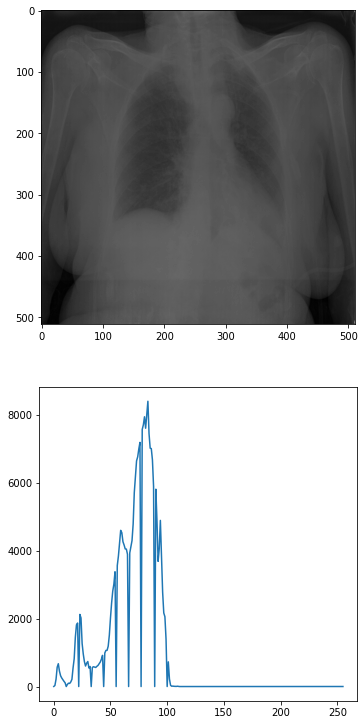

In [27]:
img = cv2.imread('../input/siim-covid19-resized-to-512px-png/train/0c6b440ba98e.png',cv2.IMREAD_UNCHANGED)
fig,ax = plt.subplots(figsize=(5.7,12.7),nrows=2,ncols=1)
ax[0].imshow(img,'gray')
hist, bin_edges = np.histogram(img, bins=2**8)
ax[1].plot(hist)
fig.savefig('/kaggle/working/without_pre.png')

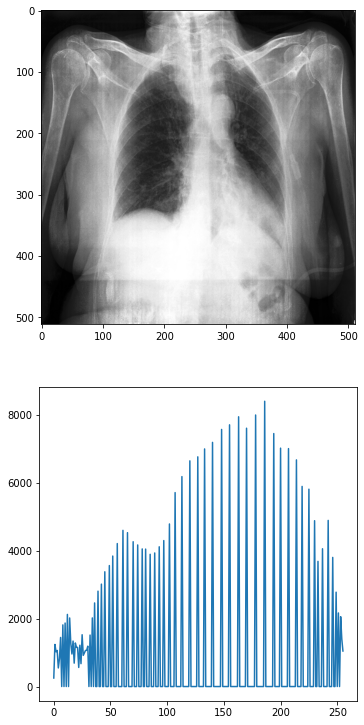

In [30]:
img_eq = cv2.equalizeHist(img)
fig,ax = plt.subplots(figsize=(5.7,12.7),nrows=2,ncols=1)
ax[0].imshow(img_eq,'gray')
hist, bin_edges = np.histogram(img_eq, bins=2**8)
ax[1].plot(hist)
fig.savefig('/kaggle/working/equalized.png')

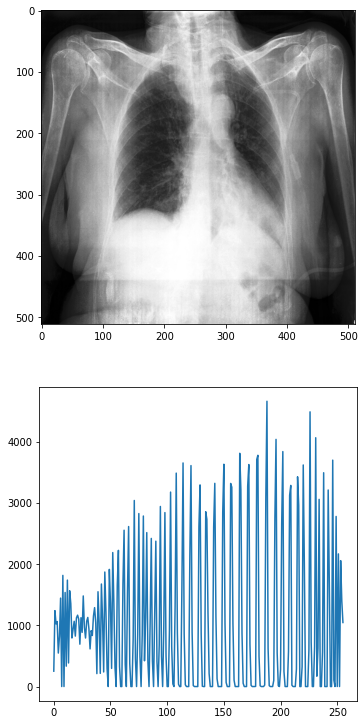

In [31]:
clahe = cv2.createCLAHE(clipLimit=0.01)
img_adapt = clahe.apply(img_eq)
fig,ax = plt.subplots(figsize=(5.7,12.7),nrows=2,ncols=1)
ax[0].imshow(img_adapt,'gray')
hist, bin_edges = np.histogram(img_adapt, bins=2**8)
ax[1].plot(hist)
fig.savefig('/kaggle/working/adapt_hist.png')

# Testing Albumentations

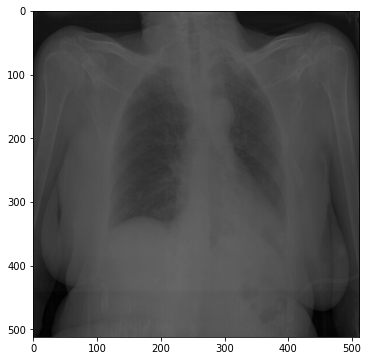

In [9]:
img = cv2.imread('../input/siim-covid19-resized-to-512px-png/train/0c6b440ba98e.png',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(12,6))
plt.imshow(img,'gray')

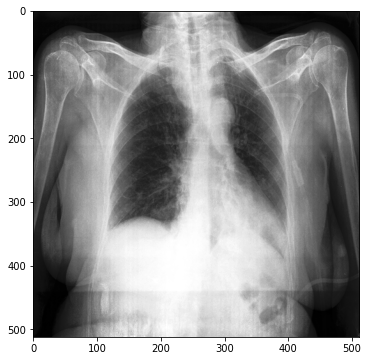

In [10]:
hist_eq = A.Equalize(p=1)
augmented_img = hist_eq(image=img)['image']
plt.figure(figsize=(12,6))
plt.imshow(augmented_img,'gray')

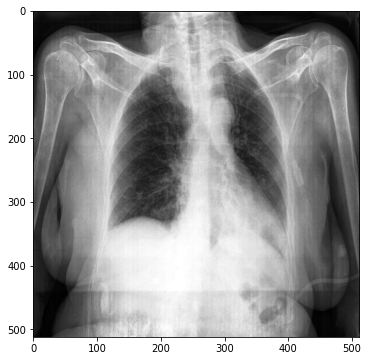

In [11]:
clahe = A.CLAHE(p=1,clip_limit=2.0)
augmented_img_2 = clahe(image=augmented_img)['image']
plt.figure(figsize=(12,6))
plt.imshow(augmented_img_2,'gray')